In [1]:
import re

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from nltk.corpus import stopwords
from bs4 import BeautifulSoup

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryConfusionMatrix

import numpy as np
from collections import defaultdict

from transformers import AutoTokenizer

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load dataset

In [3]:
dataset = load_dataset("imdb", cache_dir='./data')
dataset

Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at data\imdb\plain_text\0.0.0\e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Fri Jul 25 11:25:10 2025).


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [4]:
dataset.pop("unsupervised")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

### Find length of texts

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors


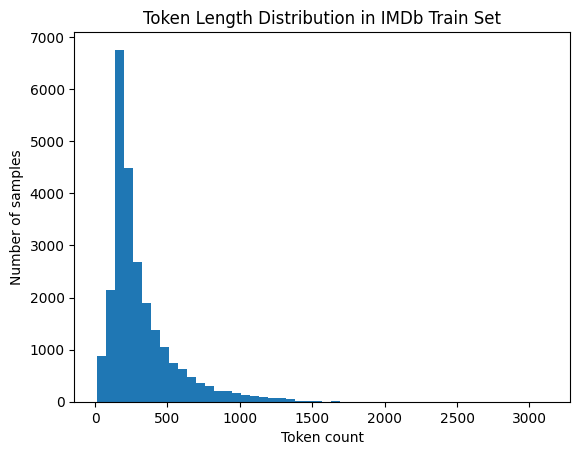

In [6]:
token_lens = []

for sample in dataset["train"]["text"]:
    tokens = tokenizer.encode(sample, truncation=False)
    token_lens.append(len(tokens))

plt.hist(token_lens, bins=50)
plt.xlabel("Token count")
plt.ylabel("Number of samples")
plt.title("Token Length Distribution in IMDb Train Set")
plt.show()


- we can use 256 for max length

### Preprocessing

In [7]:
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()               # Remove HTML
    text = re.sub(r"\[[^]]*\]", "", text)                              # Remove [brackets]
    text = re.sub(r"http\S+", "", text)                                # Remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s.,!?']", " ", text)                   # Remove special chars
    text = re.sub(r"\s+", " ", text).strip()                           # Normalize whitespace
    return text

def clean_dataset(example):
    example["text"] = clean_text(example["text"])
    return example

In [8]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

In [9]:
clean_datasets = dataset.map(clean_dataset)

tokenized_datasets = clean_datasets.map(tokenize_function, batched=True)

In [10]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
})

In [11]:
tokenized_datasets.set_format(
    type="torch",
    columns=["input_ids", "label"]
)

### Split data

In [68]:
train = tokenized_datasets['train'].train_test_split(test_size=0.2)

train

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5000
    })
})

In [69]:
val = train['test']
train = train['train']
test = tokenized_datasets['test']

### Dataloader

In [70]:
train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val, batch_size=32)
test_dataloader = DataLoader(test, batch_size=32)

### RNN model

In [106]:
class RNNC(nn.Module):
    def __init__(self, embedding_dim, vocab_size, padding_idx,
                 hidden_dim=128, num_layers=1, bidirectional=False, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=bidirectional, dropout=dropout if num_layers > 1 else 0)
        
        fc_input_dim = hidden_dim * (2 if bidirectional else 1)

        self.fc = nn.Sequential(
            nn.Linear(fc_input_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_output, hidden = self.rnn(embedded)

        if self.rnn.bidirectional:
            forward = hidden[-2,:,:]
            backward = hidden[-1,:,:]
            last_hidden = torch.cat((forward, backward), dim=1)
        else:
            last_hidden = hidden[-1]

        return self.fc(last_hidden)


### LSTM models

In [107]:
class LSTMC(nn.Module) :
    def __init__(self, embedding_dim, vocab_size, padding_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embedding_dim, 128 , num_layers=2, bidirectional=False, batch_first=True, dropout=0.5)
        self.FC = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x) :
        x = self.embedding(x)
        output , (hidden, _) = self.lstm(x)
        hidden = hidden[-1]
        return self.FC(hidden)   

In [108]:
class LSTMbidirectional(nn.Module) :
    def __init__(self, embedding_dim, vocab_size, padding_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embedding_dim, 128 , num_layers=2, bidirectional=True, batch_first=True, dropout=0.5)
        self.FC = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x) :
        x = self.embedding(x)
        output , (hidden, _) = self.lstm(x)
        hidden = torch.cat((hidden[-1], hidden[-2]), dim=1)
        return self.FC(hidden)   

In [169]:
RNNC_bidirectional = RNNC(embedding_dim=300, vocab_size=tokenizer.vocab_size, padding_idx=tokenizer.pad_token_id, bidirectional=True).to(device)
RNN_classification = RNNC(embedding_dim=300, vocab_size=tokenizer.vocab_size, padding_idx=tokenizer.pad_token_id, bidirectional=False).to(device)

LSTM_classification = LSTMC(embedding_dim=300, vocab_size=tokenizer.vocab_size, padding_idx=tokenizer.pad_token_id).to(device)
LSTM_bidirectional = LSTMC(embedding_dim=300, vocab_size=tokenizer.vocab_size, padding_idx=tokenizer.pad_token_id).to(device)

In [170]:
criterion = nn.BCEWithLogitsLoss()

optimizer_RNNB = optim.AdamW(RNNC_bidirectional.parameters(), lr=0.001)
scheduler_RNNB = optim.lr_scheduler.StepLR(optimizer_RNNB, step_size=5, gamma=0.5)

optimizer_RNNC = optim.AdamW(RNN_classification.parameters(), lr=0.001)
scheduler_RNNC = optim.lr_scheduler.StepLR(optimizer_RNNC, step_size=5, gamma=0.5)

optimizer_LSTMC = optim.AdamW(LSTM_classification.parameters(), lr=0.001)
scheduler_LSTMC = optim.lr_scheduler.StepLR(optimizer_LSTMC, step_size=10, gamma=0.5)

optimizer_LSTMB = optim.AdamW(LSTM_bidirectional.parameters(), lr=0.001)
scheduler_LSTMB = optim.lr_scheduler.StepLR(optimizer_LSTMB, step_size=10, gamma=0.5)

### Training

#### RNN

In [143]:
accuracy_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)

best_f1 = 0
patience = 8
counter = 0

for epoch in range(20):
    RNN_classification.train()
    total_loss = 0

    train_loop = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{20} [Training]', leave=False)
    for batch in train_loop:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].float().to(device)

        optimizer_RNNC.zero_grad()
        outputs = RNN_classification(input_ids)
        loss = criterion(outputs.view(-1), labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(RNN_classification.parameters(), max_norm=1.0)
        optimizer_RNNC.step()
        
        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())
    
    RNN_classification.eval()
    val_loss = 0
    accuracy_metric.reset()
    f1_metric.reset()

    with torch.no_grad() :
        val_loop = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{20} [Validation]", leave=False)
        for batch in val_loop:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].float().to(device)

            outputs = RNN_classification(input_ids)
            loss = criterion(outputs.view(-1), labels)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float().view(-1)
            accuracy_metric.update(preds, labels)
            f1_metric.update(preds, labels)

            val_loop.set_postfix(loss=loss.item())

    
    current_acc = accuracy_metric.compute().item()
    current_f1 = f1_metric.compute().item()


    print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f} || "
          f"Val Loss: {val_loss:.4f} | Acc: {current_acc:.4f} | F1: {current_f1:.4f}")
    
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        counter = 0
        torch.save(RNN_classification.state_dict(), "./models/RNNC.pth")
        print(f"Best model saved at epoch {epoch+1} with F1: {best_f1:.4f}")
    else:
        counter += 1
        print(f"No improvement for {counter} epochs (patience: {patience})")

    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. Best F1: {best_f1:.4f}")
        break
    
    scheduler_RNNC.step()

Epoch 1/20 [Training]:   0%|          | 0/625 [00:00<?, ?it/s]

[Epoch 1] Train Loss: 435.0708 || Val Loss: 109.1673 | Acc: 0.4966 | F1: 0.0210
Best model saved at epoch 1 with F1: 0.0210


[Epoch 2] Train Loss: 437.2120 || Val Loss: 108.8117 | Acc: 0.5074 | F1: 0.6168
Best model saved at epoch 2 with F1: 0.6168


[Epoch 3] Train Loss: 435.7052 || Val Loss: 109.8640 | Acc: 0.4948 | F1: 0.4288
No improvement for 1 epochs (patience: 8)


[Epoch 4] Train Loss: 435.3483 || Val Loss: 108.9654 | Acc: 0.5016 | F1: 0.5178
No improvement for 2 epochs (patience: 8)


[Epoch 5] Train Loss: 434.9687 || Val Loss: 109.0288 | Acc: 0.5020 | F1: 0.5120
No improvement for 3 epochs (patience: 8)


[Epoch 6] Train Loss: 433.8469 || Val Loss: 108.9165 | Acc: 0.4964 | F1: 0.4150
No improvement for 4 epochs (patience: 8)


[Epoch 7] Train Loss: 433.5892 || Val Loss: 108.7820 | Acc: 0.5044 | F1: 0.5617
No improvement for 5 epochs (patience: 8)


[Epoch 8] Train Loss: 433.6315 || Val Loss: 108.8186 | Acc: 0.4980 | F1: 0.5644
No improvement for 6 epochs (patience: 8)


[Epoch 9] Train Loss: 433.8661 || Val Loss: 108.7874 | Acc: 0.5126 | F1: 0.5782
No improvement for 7 epochs (patience: 8)


[Epoch 10] Train Loss: 434.1722 || Val Loss: 108.8942 | Acc: 0.4986 | F1: 0.2843
No improvement for 8 epochs (patience: 8)
Early stopping at epoch 10. Best F1: 0.6168


In [144]:
accuracy_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)

best_f1 = 0
patience = 8
counter = 0

for epoch in range(20):
    RNNC_bidirectional.train()
    total_loss = 0

    train_loop = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{20} [Training]', leave=False)
    for batch in train_loop:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].float().to(device)

        optimizer_RNNB.zero_grad()
        outputs = RNNC_bidirectional(input_ids)
        loss = criterion(outputs.view(-1), labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(RNNC_bidirectional.parameters(), max_norm=1.0)
        optimizer_RNNB.step()
        
        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())
    
    RNNC_bidirectional.eval()
    val_loss = 0
    accuracy_metric.reset()
    f1_metric.reset()

    with torch.no_grad() :
        val_loop = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{20} [Validation]", leave=False)
        for batch in val_loop:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].float().to(device)

            outputs = RNNC_bidirectional(input_ids)
            loss = criterion(outputs.view(-1), labels)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float().view(-1)
            accuracy_metric.update(preds, labels)
            f1_metric.update(preds, labels)

            val_loop.set_postfix(loss=loss.item())

    
    current_acc = accuracy_metric.compute().item()
    current_f1 = f1_metric.compute().item()


    print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f} || "
          f"Val Loss: {val_loss:.4f} | Acc: {current_acc:.4f} | F1: {current_f1:.4f}")
    
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        counter = 0
        torch.save(RNNC_bidirectional.state_dict(), "./models/RNNB.pth")
        print(f"Best model saved at epoch {epoch+1} with F1: {best_f1:.4f}")
    else:
        counter += 1
        print(f"No improvement for {counter} epochs (patience: {patience})")

    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. Best F1: {best_f1:.4f}")
        break
    
    scheduler_RNNB.step()

[Epoch 1] Train Loss: 430.9971 || Val Loss: 105.4120 | Acc: 0.5962 | F1: 0.6500
Best model saved at epoch 1 with F1: 0.6500


[Epoch 2] Train Loss: 407.3956 || Val Loss: 100.9160 | Acc: 0.6372 | F1: 0.6235
No improvement for 1 epochs (patience: 8)


[Epoch 3] Train Loss: 367.1829 || Val Loss: 99.1579 | Acc: 0.6842 | F1: 0.6717
Best model saved at epoch 3 with F1: 0.6717


[Epoch 4] Train Loss: 325.9368 || Val Loss: 91.9093 | Acc: 0.7200 | F1: 0.7324
Best model saved at epoch 4 with F1: 0.7324


[Epoch 5] Train Loss: 291.3223 || Val Loss: 92.3192 | Acc: 0.7352 | F1: 0.7353
Best model saved at epoch 5 with F1: 0.7353


[Epoch 6] Train Loss: 242.6730 || Val Loss: 103.0991 | Acc: 0.7366 | F1: 0.7307
No improvement for 1 epochs (patience: 8)


[Epoch 7] Train Loss: 214.5883 || Val Loss: 101.1276 | Acc: 0.7184 | F1: 0.7174
No improvement for 2 epochs (patience: 8)


[Epoch 8] Train Loss: 190.2756 || Val Loss: 114.3085 | Acc: 0.7246 | F1: 0.7432
Best model saved at epoch 8 with F1: 0.7432


[Epoch 9] Train Loss: 168.9440 || Val Loss: 124.8621 | Acc: 0.7296 | F1: 0.7319
No improvement for 1 epochs (patience: 8)


[Epoch 10] Train Loss: 147.8653 || Val Loss: 116.1756 | Acc: 0.7304 | F1: 0.7349
No improvement for 2 epochs (patience: 8)


[Epoch 11] Train Loss: 120.9030 || Val Loss: 135.3164 | Acc: 0.7308 | F1: 0.7365
No improvement for 3 epochs (patience: 8)


[Epoch 12] Train Loss: 105.0870 || Val Loss: 141.3089 | Acc: 0.7280 | F1: 0.7275
No improvement for 4 epochs (patience: 8)


[Epoch 13] Train Loss: 95.0634 || Val Loss: 152.2265 | Acc: 0.7206 | F1: 0.7195
No improvement for 5 epochs (patience: 8)


[Epoch 14] Train Loss: 86.0364 || Val Loss: 152.6025 | Acc: 0.7256 | F1: 0.7309
No improvement for 6 epochs (patience: 8)


[Epoch 15] Train Loss: 77.0960 || Val Loss: 151.9437 | Acc: 0.7252 | F1: 0.7244
No improvement for 7 epochs (patience: 8)


[Epoch 16] Train Loss: 64.6346 || Val Loss: 175.3216 | Acc: 0.7224 | F1: 0.7277
No improvement for 8 epochs (patience: 8)
Early stopping at epoch 16. Best F1: 0.7432


In [171]:
RNN_classification.load_state_dict(torch.load("./models/RNNC.pth"))
RNNC_bidirectional.load_state_dict(torch.load("./models/RNNB.pth"))

<All keys matched successfully>

#### LSTM

In [172]:
accuracy_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)

best_f1 = 0
patience = 10
counter = 0

for epoch in range(30):
    LSTM_classification.train()
    total_loss = 0

    train_loop = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{30} [Training]', leave=False)
    for batch in train_loop:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].float().to(device)

        optimizer_LSTMC.zero_grad()
        outputs = LSTM_classification(input_ids)
        loss = criterion(outputs.view(-1), labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(LSTM_classification.parameters(), max_norm=1.0)
        optimizer_LSTMC.step()
        
        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())
    
    LSTM_classification.eval()
    val_loss = 0
    accuracy_metric.reset()
    f1_metric.reset()

    with torch.no_grad() :
        val_loop = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{30} [Validation]", leave=False)
        for batch in val_loop:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].float().to(device)

            outputs = LSTM_classification(input_ids)
            loss = criterion(outputs.view(-1), labels)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float().view(-1)
            accuracy_metric.update(preds, labels)
            f1_metric.update(preds, labels)

            val_loop.set_postfix(loss=loss.item())

    
    current_acc = accuracy_metric.compute().item()
    current_f1 = f1_metric.compute().item()


    print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f} || "
          f"Val Loss: {val_loss:.4f} | Acc: {current_acc:.4f} | F1: {current_f1:.4f}")
    
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        counter = 0
        torch.save(LSTM_classification.state_dict(), "./models/LSTMC.pth")
        print(f"Best model saved at epoch {epoch+1} with F1: {best_f1:.4f}")
    else:
        counter += 1
        print(f"No improvement for {counter} epochs (patience: {patience})")

    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. Best F1: {best_f1:.4f}")
        break
    
    scheduler_LSTMC.step()

[Epoch 1] Train Loss: 433.2452 || Val Loss: 108.2218 | Acc: 0.5320 | F1: 0.6425
Best model saved at epoch 1 with F1: 0.6425


[Epoch 2] Train Loss: 422.0678 || Val Loss: 107.7997 | Acc: 0.5350 | F1: 0.6584
Best model saved at epoch 2 with F1: 0.6584


[Epoch 3] Train Loss: 366.5329 || Val Loss: 93.8869 | Acc: 0.7012 | F1: 0.7501
Best model saved at epoch 3 with F1: 0.7501


[Epoch 4] Train Loss: 262.3733 || Val Loss: 86.1826 | Acc: 0.7600 | F1: 0.7707
Best model saved at epoch 4 with F1: 0.7707


[Epoch 5] Train Loss: 200.1509 || Val Loss: 98.7910 | Acc: 0.7726 | F1: 0.7950
Best model saved at epoch 5 with F1: 0.7950


[Epoch 6] Train Loss: 162.9144 || Val Loss: 92.7486 | Acc: 0.7896 | F1: 0.8083
Best model saved at epoch 6 with F1: 0.8083


[Epoch 7] Train Loss: 130.2325 || Val Loss: 91.3330 | Acc: 0.8108 | F1: 0.8027
No improvement for 1 epochs (patience: 10)


[Epoch 8] Train Loss: 95.4495 || Val Loss: 100.5479 | Acc: 0.8174 | F1: 0.8188
Best model saved at epoch 8 with F1: 0.8188


[Epoch 9] Train Loss: 68.8668 || Val Loss: 97.5527 | Acc: 0.8198 | F1: 0.8156
No improvement for 1 epochs (patience: 10)


[Epoch 10] Train Loss: 48.0415 || Val Loss: 121.5900 | Acc: 0.8156 | F1: 0.8246
Best model saved at epoch 10 with F1: 0.8246


[Epoch 11] Train Loss: 31.0813 || Val Loss: 133.5882 | Acc: 0.8256 | F1: 0.8337
Best model saved at epoch 11 with F1: 0.8337


[Epoch 12] Train Loss: 22.2499 || Val Loss: 138.5428 | Acc: 0.8202 | F1: 0.8244
No improvement for 1 epochs (patience: 10)


[Epoch 13] Train Loss: 14.6581 || Val Loss: 160.3394 | Acc: 0.8172 | F1: 0.8059
No improvement for 2 epochs (patience: 10)


[Epoch 14] Train Loss: 11.7805 || Val Loss: 156.7774 | Acc: 0.8284 | F1: 0.8291
No improvement for 3 epochs (patience: 10)


[Epoch 15] Train Loss: 9.7792 || Val Loss: 172.4680 | Acc: 0.8326 | F1: 0.8367
Best model saved at epoch 15 with F1: 0.8367


[Epoch 16] Train Loss: 8.6371 || Val Loss: 178.3339 | Acc: 0.8284 | F1: 0.8324
No improvement for 1 epochs (patience: 10)


[Epoch 17] Train Loss: 9.6180 || Val Loss: 180.9289 | Acc: 0.8282 | F1: 0.8367
Best model saved at epoch 17 with F1: 0.8367


[Epoch 18] Train Loss: 8.7578 || Val Loss: 189.3207 | Acc: 0.8250 | F1: 0.8339
No improvement for 1 epochs (patience: 10)


[Epoch 19] Train Loss: 9.6822 || Val Loss: 185.4161 | Acc: 0.8256 | F1: 0.8262
No improvement for 2 epochs (patience: 10)


[Epoch 20] Train Loss: 8.4223 || Val Loss: 211.9076 | Acc: 0.8210 | F1: 0.8230
No improvement for 3 epochs (patience: 10)


[Epoch 21] Train Loss: 6.7593 || Val Loss: 211.4985 | Acc: 0.8206 | F1: 0.8232
No improvement for 4 epochs (patience: 10)


[Epoch 22] Train Loss: 6.3054 || Val Loss: 214.7807 | Acc: 0.8210 | F1: 0.8245
No improvement for 5 epochs (patience: 10)


[Epoch 23] Train Loss: 5.3947 || Val Loss: 238.9883 | Acc: 0.8218 | F1: 0.8253
No improvement for 6 epochs (patience: 10)


[Epoch 24] Train Loss: 5.5144 || Val Loss: 226.5190 | Acc: 0.8270 | F1: 0.8311
No improvement for 7 epochs (patience: 10)


[Epoch 25] Train Loss: 5.8241 || Val Loss: 239.1202 | Acc: 0.8160 | F1: 0.8178
No improvement for 8 epochs (patience: 10)


[Epoch 26] Train Loss: 5.7940 || Val Loss: 222.4707 | Acc: 0.8264 | F1: 0.8335
No improvement for 9 epochs (patience: 10)


[Epoch 27] Train Loss: 6.2505 || Val Loss: 232.5555 | Acc: 0.8194 | F1: 0.8228
No improvement for 10 epochs (patience: 10)
Early stopping at epoch 27. Best F1: 0.8367


In [173]:
accuracy_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)

best_f1 = 0
patience = 10
counter = 0

for epoch in range(30):
    LSTM_bidirectional.train()
    total_loss = 0

    train_loop = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{30} [Training]', leave=False)
    for batch in train_loop:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].float().to(device)

        optimizer_LSTMB.zero_grad()
        outputs = LSTM_bidirectional(input_ids)
        loss = criterion(outputs.view(-1), labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(LSTM_bidirectional.parameters(), max_norm=1.0)
        optimizer_LSTMB.step()
        
        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())
    
    LSTM_bidirectional.eval()
    val_loss = 0
    accuracy_metric.reset()
    f1_metric.reset()

    with torch.no_grad() :
        val_loop = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{30} [Validation]", leave=False)
        for batch in val_loop:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].float().to(device)

            outputs = LSTM_bidirectional(input_ids)
            loss = criterion(outputs.view(-1), labels)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float().view(-1)
            accuracy_metric.update(preds, labels)
            f1_metric.update(preds, labels)

            val_loop.set_postfix(loss=loss.item())

    
    current_acc = accuracy_metric.compute().item()
    current_f1 = f1_metric.compute().item()


    print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f} || "
          f"Val Loss: {val_loss:.4f} | Acc: {current_acc:.4f} | F1: {current_f1:.4f}")
    
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        counter = 0
        torch.save(LSTM_bidirectional.state_dict(), "./models/LSTMB.pth")
        print(f"Best model saved at epoch {epoch+1} with F1: {best_f1:.4f}")
    else:
        counter += 1
        print(f"No improvement for {counter} epochs (patience: {patience})")

    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. Best F1: {best_f1:.4f}")
        break
    
    scheduler_LSTMB.step()

[Epoch 1] Train Loss: 433.1312 || Val Loss: 108.3141 | Acc: 0.5282 | F1: 0.6141
Best model saved at epoch 1 with F1: 0.6141


[Epoch 2] Train Loss: 426.1778 || Val Loss: 107.6700 | Acc: 0.5120 | F1: 0.6276
Best model saved at epoch 2 with F1: 0.6276


[Epoch 3] Train Loss: 395.3572 || Val Loss: 96.8271 | Acc: 0.6748 | F1: 0.5955
No improvement for 1 epochs (patience: 10)


[Epoch 4] Train Loss: 313.5064 || Val Loss: 76.1443 | Acc: 0.7978 | F1: 0.7984
Best model saved at epoch 4 with F1: 0.7984


[Epoch 5] Train Loss: 189.9184 || Val Loss: 66.9628 | Acc: 0.8254 | F1: 0.8293
Best model saved at epoch 5 with F1: 0.8293


[Epoch 6] Train Loss: 116.4692 || Val Loss: 73.6480 | Acc: 0.8290 | F1: 0.8211
No improvement for 1 epochs (patience: 10)


[Epoch 7] Train Loss: 70.9535 || Val Loss: 92.4962 | Acc: 0.8324 | F1: 0.8222
No improvement for 2 epochs (patience: 10)


[Epoch 8] Train Loss: 41.9103 || Val Loss: 100.9194 | Acc: 0.8352 | F1: 0.8308
Best model saved at epoch 8 with F1: 0.8308


[Epoch 9] Train Loss: 29.2477 || Val Loss: 125.8242 | Acc: 0.8296 | F1: 0.8248
No improvement for 1 epochs (patience: 10)


[Epoch 10] Train Loss: 22.7832 || Val Loss: 134.1125 | Acc: 0.8340 | F1: 0.8266
No improvement for 2 epochs (patience: 10)


[Epoch 11] Train Loss: 11.1975 || Val Loss: 160.6423 | Acc: 0.8296 | F1: 0.8211
No improvement for 3 epochs (patience: 10)


[Epoch 12] Train Loss: 9.1655 || Val Loss: 170.4012 | Acc: 0.8320 | F1: 0.8340
Best model saved at epoch 12 with F1: 0.8340


[Epoch 13] Train Loss: 7.4148 || Val Loss: 177.9173 | Acc: 0.8340 | F1: 0.8352
Best model saved at epoch 13 with F1: 0.8352


[Epoch 14] Train Loss: 6.2405 || Val Loss: 207.7263 | Acc: 0.8262 | F1: 0.8349
No improvement for 1 epochs (patience: 10)


[Epoch 15] Train Loss: 6.3597 || Val Loss: 189.2761 | Acc: 0.8312 | F1: 0.8333
No improvement for 2 epochs (patience: 10)


[Epoch 16] Train Loss: 6.9975 || Val Loss: 212.4361 | Acc: 0.8312 | F1: 0.8329
No improvement for 3 epochs (patience: 10)


[Epoch 17] Train Loss: 7.6678 || Val Loss: 197.6363 | Acc: 0.8306 | F1: 0.8304
No improvement for 4 epochs (patience: 10)


[Epoch 18] Train Loss: 5.9521 || Val Loss: 193.5636 | Acc: 0.8322 | F1: 0.8345
No improvement for 5 epochs (patience: 10)


[Epoch 19] Train Loss: 6.4616 || Val Loss: 202.8523 | Acc: 0.8326 | F1: 0.8344
No improvement for 6 epochs (patience: 10)


[Epoch 20] Train Loss: 6.1897 || Val Loss: 201.2547 | Acc: 0.8292 | F1: 0.8276
No improvement for 7 epochs (patience: 10)


[Epoch 21] Train Loss: 3.8043 || Val Loss: 202.6709 | Acc: 0.8346 | F1: 0.8375
Best model saved at epoch 21 with F1: 0.8375


[Epoch 22] Train Loss: 3.0748 || Val Loss: 218.7418 | Acc: 0.8322 | F1: 0.8337
No improvement for 1 epochs (patience: 10)


[Epoch 23] Train Loss: 2.5656 || Val Loss: 231.9390 | Acc: 0.8380 | F1: 0.8381
Best model saved at epoch 23 with F1: 0.8381


[Epoch 24] Train Loss: 3.8050 || Val Loss: 229.9200 | Acc: 0.8348 | F1: 0.8307
No improvement for 1 epochs (patience: 10)


[Epoch 25] Train Loss: 3.0988 || Val Loss: 236.2028 | Acc: 0.8336 | F1: 0.8295
No improvement for 2 epochs (patience: 10)


[Epoch 26] Train Loss: 3.8905 || Val Loss: 232.1578 | Acc: 0.8300 | F1: 0.8346
No improvement for 3 epochs (patience: 10)


[Epoch 27] Train Loss: 2.5829 || Val Loss: 237.6860 | Acc: 0.8334 | F1: 0.8340
No improvement for 4 epochs (patience: 10)


[Epoch 28] Train Loss: 2.7102 || Val Loss: 248.5273 | Acc: 0.8258 | F1: 0.8274
No improvement for 5 epochs (patience: 10)


[Epoch 29] Train Loss: 2.1844 || Val Loss: 261.7936 | Acc: 0.8256 | F1: 0.8296
No improvement for 6 epochs (patience: 10)


[Epoch 30] Train Loss: 2.9129 || Val Loss: 249.6486 | Acc: 0.8324 | F1: 0.8295
No improvement for 7 epochs (patience: 10)


In [174]:
LSTM_classification.load_state_dict(torch.load("./models/LSTMC.pth"))
LSTM_bidirectional.load_state_dict(torch.load("./models/LSTMB.pth"))

<All keys matched successfully>

### Test

In [175]:
def creat_heatmap(confusion_matrix) :
    plt.figure(figsize=(12, 7))
    sns.heatmap(confusion_matrix.compute().to('cpu'),
                annot=True, 
                fmt='d', 
                cmap='Blues', 
                linewidths=0.5, 
                square=True, 
                cbar_kws={"shrink": 0.75}
    )


    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

In [192]:
def Test_verification(model):
    accuracy_metric_test = BinaryAccuracy().to(device)
    f1_metric_test = BinaryF1Score().to(device)
    CF = BinaryConfusionMatrix().to(device)

    model.eval()
    with torch.no_grad():
        val_loop = tqdm(test_dataloader, desc="Test [Evaluation]", leave=False)
        for batch in val_loop:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].float().to(device)

            outputs = model(input_ids)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float().squeeze(1)

            accuracy_metric_test.update(preds, labels)
            f1_metric_test.update(preds, labels)
            CF.update(preds, labels)

    print(f"Test F1: {f1_metric_test.compute().item():.4f}")
    print(f"Test Accuracy: {accuracy_metric_test.compute().item():.4f}")

    creat_heatmap(CF)


Test F1: 0.6156
Test Accuracy: 0.5048


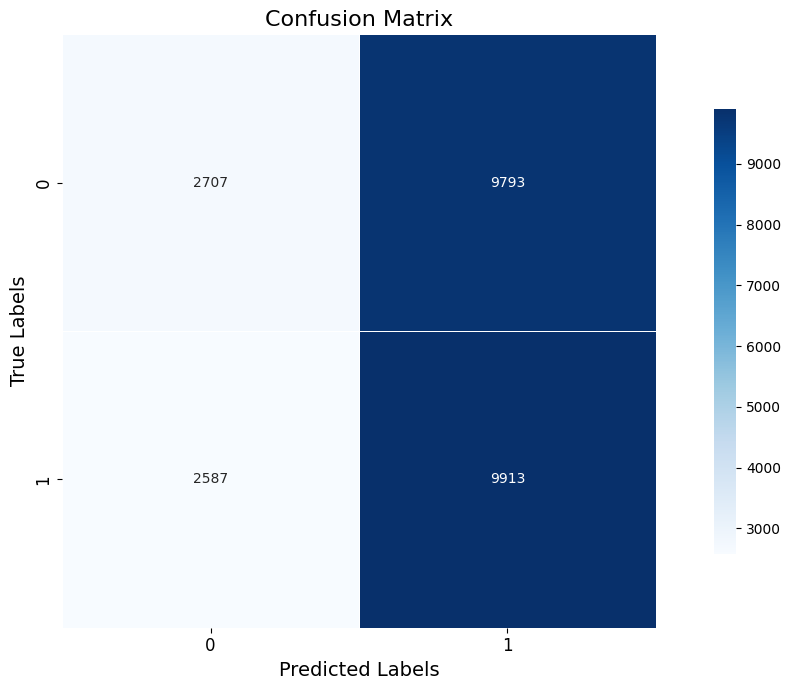

In [193]:
Test_verification(RNN_classification)

Test F1: 0.7173
Test Accuracy: 0.7061


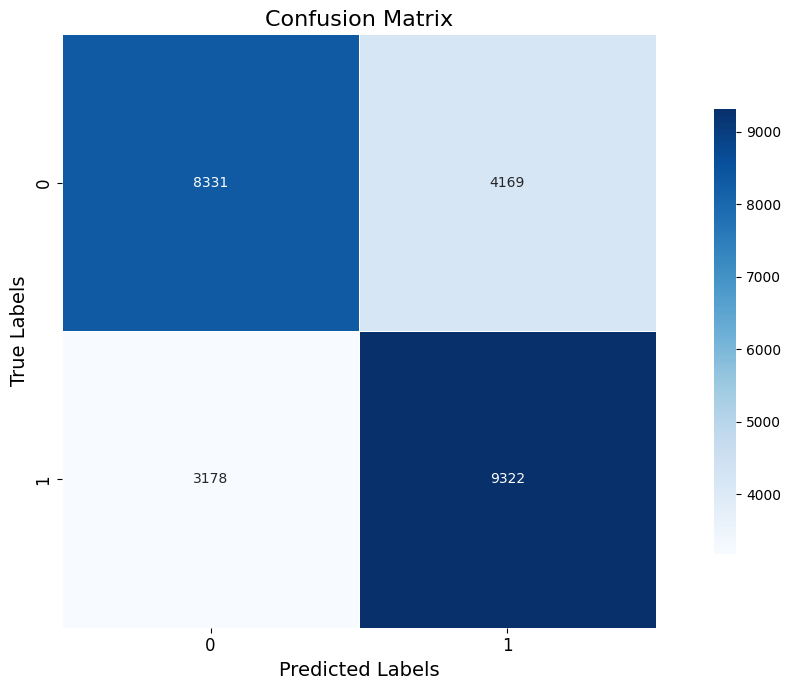

In [194]:
Test_verification(RNNC_bidirectional)

Test F1: 0.8238
Test Accuracy: 0.8182


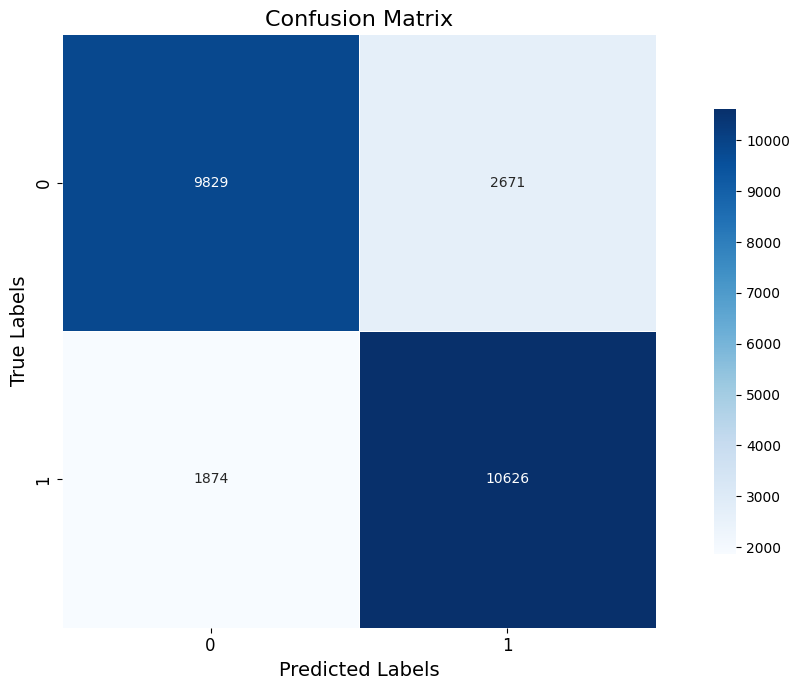

In [195]:
Test_verification(LSTM_classification)

Test F1: 0.8159
Test Accuracy: 0.8193


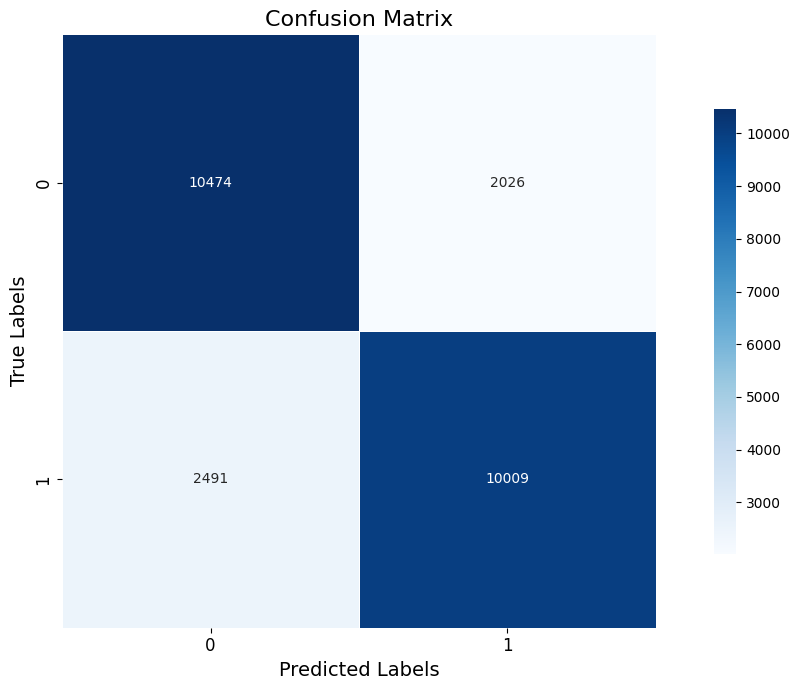

In [196]:
Test_verification(LSTM_bidirectional)

# 📊 Model Performance Summary

## 🧠 Model 1: `RNN`
**Best Validation F1:** `0.6168` (Epoch 2)  
**Early Stopping:** Epoch 10  
**Test F1:** `0.6156`  
**Test Accuracy:** `0.5048`

| Epoch | Train Loss | Val Loss | Accuracy | F1 Score | Note |
|-------|------------|----------|----------|----------|------|
| 1     | 435.0708   | 109.1673 | 0.4966   | 0.0210   | ✅ Best |
| 2     | 437.2120   | 108.8117 | 0.5074   | 0.6168   | ✅ Best |
| ...   | ...        | ...      | ...      | ...      | No improvement |
| 10    | 434.1722   | 108.8942 | 0.4986   | 0.2843   | ⛔ Early Stopping |

---

## 🔁 Model 2: `RNN_bidirectional`
**Best Validation F1:** `0.7432` (Epoch 8)  
**Early Stopping:** Epoch 16  
**Test F1:** `0.7173`  
**Test Accuracy:** `0.7061`

| Epoch | Train Loss | Val Loss | Accuracy | F1 Score | Note |
|-------|------------|----------|----------|----------|------|
| 1     | 430.9971   | 105.4120 | 0.5962   | 0.6500   | ✅ Best |
| 4     | 325.9368   | 91.9093  | 0.7200   | 0.7324   | ✅ Best |
| 5     | 291.3223   | 92.3192  | 0.7352   | 0.7353   | ✅ Best |
| 8     | 190.2756   | 114.3085 | 0.7246   | 0.7432   | ✅ Best |
| 16    | 64.6346    | 175.3216 | 0.7224   | 0.7277   | ⛔ Early Stopping |

---

## 📥 Model 3: `LSTM`
**Best Validation F1:** `0.8367` (Epochs 15 & 17)  
**Early Stopping:** Epoch 27  
**Test F1:** `0.8238`  
**Test Accuracy:** `0.8182`

| Epoch | Train Loss | Val Loss | Accuracy | F1 Score | Note |
|-------|------------|----------|----------|----------|------|
| 1     | 433.2452   | 108.2218 | 0.5320   | 0.6425   | ✅ Best |
| 6     | 162.9144   | 92.7486  | 0.7896   | 0.8083   | ✅ Best |
| 8     | 95.4495    | 100.5479 | 0.8174   | 0.8188   | ✅ Best |
| 10    | 48.0415    | 121.5900 | 0.8156   | 0.8246   | ✅ Best |
| 11    | 31.0813    | 133.5882 | 0.8256   | 0.8337   | ✅ Best |
| 15    | 9.7792     | 172.4680 | 0.8326   | 0.8367   | ✅ Best |
| 17    | 9.6180     | 180.9289 | 0.8282   | 0.8367   | ✅ Best |
| 27    | 6.2505     | 232.5555 | 0.8194   | 0.8228   | ⛔ Early Stopping |

---

## 🔁 Model 4: `LSTM_bidirectional`
**Best Validation F1:** `0.8381` (Epoch 23)  
**Early Stopping:** Epoch 30  
**Test F1:** `0.8159`  
**Test Accuracy:** `0.8193`

| Epoch | Train Loss | Val Loss | Accuracy | F1 Score | Note |
|-------|------------|----------|----------|----------|------|
| 1     | 433.1312   | 108.3141 | 0.5282   | 0.6141   | ✅ Best |
| 5     | 189.9184   | 66.9628  | 0.8254   | 0.8293   | ✅ Best |
| 8     | 41.9103    | 100.9194 | 0.8352   | 0.8308   | ✅ Best |
| 12    | 9.1655     | 170.4012 | 0.8320   | 0.8340   | ✅ Best |
| 13    | 7.4148     | 177.9173 | 0.8340   | 0.8352   | ✅ Best |
| 21    | 3.8043     | 202.6709 | 0.8346   | 0.8375   | ✅ Best |
| 23    | 2.5656     | 231.9390 | 0.8380   | 0.8381   | ✅ Best |
| 30    | 2.9129     | 249.6486 | 0.8324   | 0.8295   | ⛔ Early Stopping |

---

## ✅ **Overall Summary**

| Model                | Best Val F1 | Test F1 | Test Accuracy |
|---------------------|-------------|---------|----------------|
| RNN  | 0.6168      | 0.6156  | 0.5048         |
| RNN_bidirectional   | 0.7432      | 0.7173  | 0.7061         |
| LSTM                | 0.8367      | 0.8238  | 0.8182         |
| LSTM_bidirectional  | **0.8381**  | 0.8159  | **0.8193**     |
